## Sequence Processing with RNNs and Attention

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math608/blob/master/static_files/presentations/10_Recurrent Neural Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math608/blob/master/static_files/presentations/10_Recurrent Neural Networks.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
import sys
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U transformers
    %pip install -q -U datasets
    %pip install -q -U evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.4 MB/s eta 0:00:00


In [2]:
# Python ≥3.7 is recommended
assert sys.version_info >= (3, 7)
import os
import shutil
import random
from pathlib import Path
from time import strftime
import string

# Scikit-Learn ≥1.01 is recommended
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Tensorflow ≥2.8.0 is recommended
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")

# Huggingface transformer
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import load_dataset
import evaluate

# Common imports
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

## Basic RNNs for forecasting times series

### Get the Dataset

Let's pretend you've just been hired as a data scientist by Chicago's Transit
Authority. Your first task is to build a model capable of forecasting the  number of passengers that will ride on bus and rail the next day. You have access to daily ridership data since 2001. Let’s walk through together how you would handle this. Let's download the organized ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97):

In [ ]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

We’ll start by loading and cleaning up the data:

In [ ]:
path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # gives columns with shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail which may be non-informative
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

We  load  the  CSV  file,  set  short  column  names,  sort  the  rows  by  date,  remove  the redundant  total  column, and drop duplicate rows. Now let’s check what the first few rows look like:

In [ ]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


On January 1st, 2001, 297,192 people boarded a bus in Chicago, and 126,455 boarded a train. The `day_type` column contains **W** for Weekdays, **A** for Saturdays, and **U** for Sundays or holidays. Now let’s plot the bus and rail ridership figures over a few months in 2019, to see what it looks like:

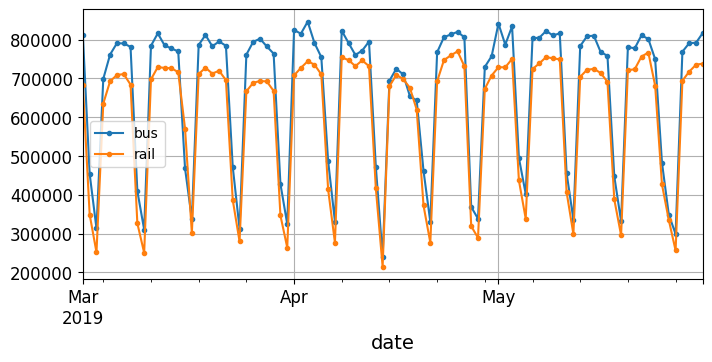

In [ ]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5));

This is a time series: data with values at different time steps, usually at regular intervals. More specifically, since there are multiple values per time step, this is called a **multivariate time series**. If we only looked at the bus column, it would be a **univariate time series**, with a single value per time step. Typical tasks are:

1. Predicting future values (i.e., forecasting) is the most typical task when dealing with time series, and this is what we will focus on. 

2. Other tasks include imputation (filling in missing past values), classification, anomaly detection, and more.

### Computing Some Baselines

We can see that a similar pattern is clearly repeated every week. This is called a weekly *seasonality*. In fact, it’s so strong in this case that
forecasting tomorrow’s ridership by just copying the values from a week earlier will yield reasonably good results. This is called **naive forecasting**: simply copying a past value to make our forecast. Naive forecasting is often a great baseline, and it can even be tricky to beat in some cases.

To visualize these naive forecasts, let’s overlay the two time series (for bus and rail) as well as the same time series lagged by one week (i.e., shifted toward the right) using dotted lines. We’ll also plot the difference between the two (i.e., the value at time $t$ minus the value at time $t–7$); this is called *differencing*:

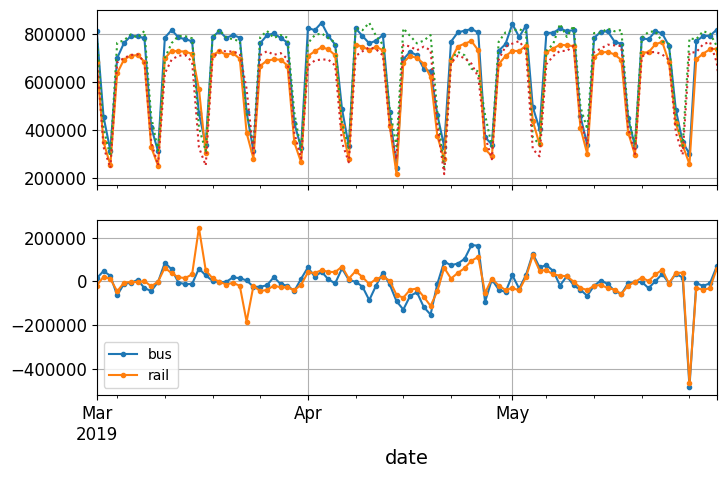

In [ ]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged time series
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000]);  # extra code – beautifies the plot

Notice how closely the lagged time series track the actual time series.
**When a time series is correlated with a lagged version of itself, we say that the time series is autocorrelated.** As you can see, most of the differences are fairly small, except at the end of May. Maybe there was a holiday at that time? Let’s check the `day_type` column:

In [ ]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Indeed, there was a long weekend back then: the Monday was the Memorial Day
holiday. We could use this column to improve our forecasts, but for now let’s just measure the mean absolute error over the three-month period we’re arbitrarily focusing on previously — March, April, and May 2019 — to get a rough idea:

In [ ]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Our naive forecasts get an MAE of about 43,916 bus riders, and about 42,143 rail
riders. It’s hard to tell at a glance how good or bad this is, so let’s put the forecast errors into perspective by dividing them by the target values:

In [ ]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

What we just computed is called the **mean absolute percentage error (MAPE)**: it looks like our naive forecasts give us a MAPE of roughly 8.3% for bus and 9.0% for rail. It’s interesting to note that the MAE for the rail forecasts looks slightly better than the MAE for the bus forecasts, while the opposite is true for the MAPE. That’s because the bus ridership is larger than the rail ridership, so naturally the forecast errors are also larger, but when we put the errors into perspective, it turns out that the bus forecasts are actually slightly better than the rail forecasts.

Looking at the time series, there doesn't appear to be any significant monthly seasonality, but let's check whether there’s any yearly seasonality. We'll look at the data from 2001 to 2019. To reduce the risk of data snooping, we'll ignore more recent data for now. Lets also plot a 12-month rolling average for each series to visualize long-term trends:

<ipython-input-20-48b45ef37fb8>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample('M').mean()  # compute the mean for each month


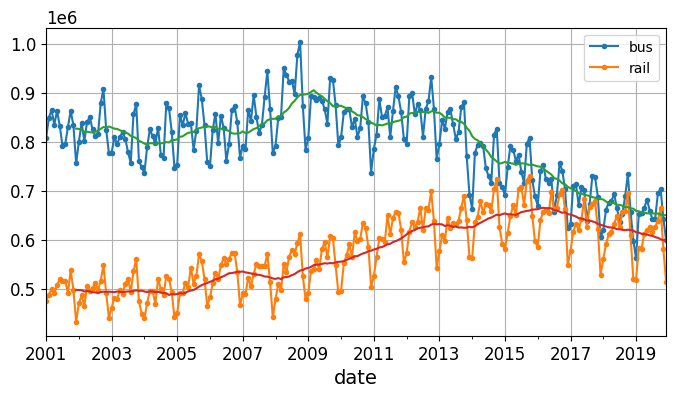

In [ ]:
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly["2001":"2019"].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly["2001":"2019"].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False);

There’s definitely some yearly seasonality as well, although it is noisier than the weekly seasonality, and more visible for the rail series than the bus series: we see peaks and troughs at roughly the same dates each year. Let’s check what we get if we plot the 12-month difference:

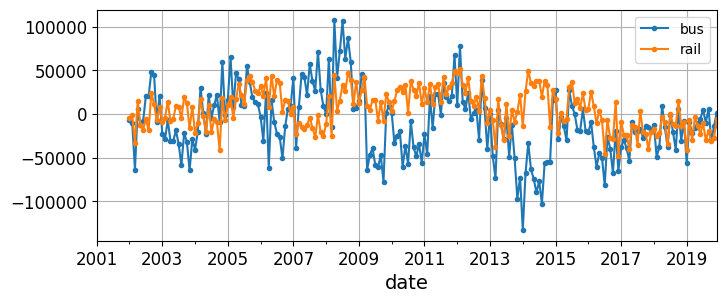

In [ ]:
df_monthly.diff(12)["2001":"2019"].plot(grid=True, marker=".", figsize=(8, 3));

Notice how differencing not only removed the yearly seasonality, but it also removed the long-term trends. For example, the linear downward trend present in the time series from 2016 to 2019 became a roughly constant negative value in the differenced time series. In fact, differencing is a common technique used to remove trend and seasonality from a time series: it’s easier to study a **stationary** time series, meaning one whose statistical properties remain constant over time, without any seasonality or trends. **Once you’re able to make accurate forecasts on the differenced time series, it’s easy to turn them into forecasts for the actual time series by just adding back the past values that were previously subtracted.**

You may be thinking that we’re only trying to predict tomorrow’s ridership, so the long-term patterns matter much less than the short-term ones. But still, we may be able to improve performance slightly by taking long-term patterns into account. For example, daily bus ridership dropped by about 2,500 in October 2017, which represents about 570 fewer passengers each week, so if we were at the end of October 2017, **it would make sense to forecast tomorrow’s ridership by copying the value from last week, minus 570.** Accounting for the trend will make your forecasts a bit more accurate on average.

### The ARMA Model Family

We’ll start with the *autoregressive moving average (ARMA) model*, developed by
Herman Wold in the 1930s: it computes its forecasts using a simple weighted sum
of lagged values and corrects these forecasts by adding a moving average. Specifically, the moving average component is computed using a weighted sum of the last few forecast errors. This model assumes that the time series is stationary. If it is not, then differencing may help. Using differencing over a single time step will produce an approximation of the derivative of the time series. If the original time series has a quadratic trend instead of a linear trend, then a single round of differencing will not be enough. In this case, running `d` consecutive rounds of differencing computes an approximation of the `d`-th order derivative of the time series, so it will eliminate polynomial trends up to degree `d`. This hyperparameter `d` is called the **order of integration**. Differencing is the central contribution of the *autoregressive integrated moving average (ARIMA) model*, introduced in 1970 by George Box and Gwilym Jenkins in their book: this model runs `d` rounds of differencing to make the time series more stationary, then it applies a regular ARMA model. When making forecasts, it uses this ARMA model, then it adds back the terms that were subtracted by differencing.

Let’s see how to fit a SARIMA model to the rail time series, and use it to make a forecast for tomorrow’s ridership. We’ll pretend today is the last day of May 2019, and we want to forecast the rail ridership for “tomorrow”, the 1st of June, 2019. For this, we can use the `statsmodels` library, which contains many different statistical models, including the ARMA model and its variants, implemented by the [`ARIMA`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html) class:

In [ ]:
origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D") # Convert time series to specified frequency
model = ARIMA(rail_series, order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast() 

y_pred[0]  # ARIMA forecast 

427758.62641035335

In [ ]:
print(df["rail"].loc["2019-06-01"])  # target value
print(df["rail"].loc["2019-05-25"])  # naive forecast (value from one week earlier)

379044
426932


- We start by importing the `ARIMA` class, then we take the rail ridership data from the start of 2019 up to “today”, and we use `asfreq("D")` to set the time series’frequency to daily: this doesn’t change the data at all in this case, since it’s already daily, but without this the `ARIMA` class would have to guess the frequency, and it would display a warning.

- We create an `ARIMA` instance, passing it all the data until “today”, and we set the model hyperparameters: `order=(1, 0, 0)` and
`seasonal_order=(0, 1, 1, 7)` for the model (See API for more descriptions). Notice that the `statsmodels` API differs a bit from `Scikit-Learn`’s API, since we pass the data to the model at construction time, instead of passing it to the `fit()` method.

The forecast is 427,759 passengers, when in fact there were 379,044. Yikes, we’re 12.9% off - that’s pretty bad. It’s actually slightly worse than naive forecasting, which forecasts 426,932, off by 12.6%. But perhaps we were just unlucky that day? To check this, we can run the same code in a loop to make forecasts for every day in March, April, and May, and compute the MAE over that period:

In [ ]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")

y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data from January up to "today", expanding window approach
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae

32040.720089453378

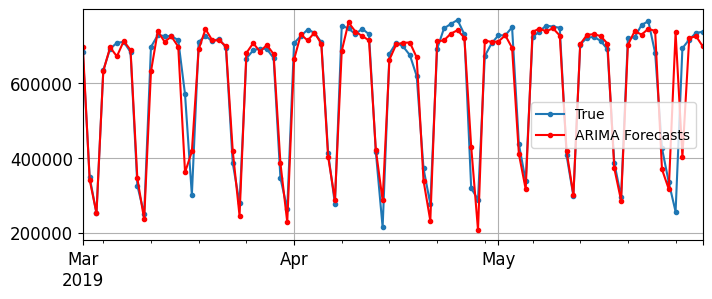

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="ARIMA Forecasts")
plt.legend();

That’s much better! The MAE is about 32,041, which is significantly lower than
the MAE we got with naive forecasting (42,143). So although the model is not perfect, it still beats naive forecasting by a large margin, on average. There are approaches for selecting good hyperparameters, based on analyzing the autocorrelation function (ACF) and partial autocorrelation function (PACF), or minimizing the AIC or BIC metrics to penalize models that use too many parameters and reduce the risk of overfitting the data:

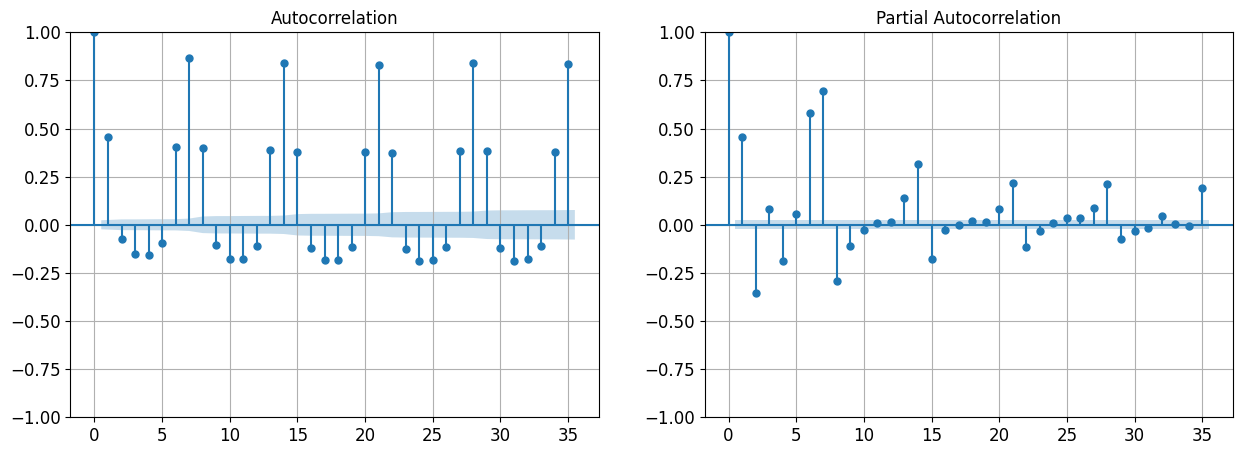

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df["2001":"2019"]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df["2001":"2019"]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid();

Refer to [https://www.statsmodels.org/devel/graphics.html#time-series-plots](https://www.statsmodels.org/devel/graphics.html#time-series-plots) for more details.

### Preparing the Data for Machine Learning Models

Now that we have two baselines, naive forecasting and ARIMA, let’s try to use the machine learning models we’ve covered so far to forecast this time series, starting with a basic linear model. Our goal will be to forecast tomorrow’s ridership based on the ridership of the past 8 weeks of data (56 days). The inputs to our model will therefore be sequences (usually a single sequence per day once the model is in production), each containing 56 values from time steps $t–55$ to $t$. For each input sequence, the model will output a single value: the forecast for time step $t+1$. We will use every 56-day window from the past as training data, and the target for each window will be the value immediately following it.

`tf.Keras` actually has a nice utility function called `tf.keras.utils.timeseries_dataset_from_array()` to help us prepare the training set. It takes a time series as input, and it builds a `tf.data.Dataset` containing all the windows of the desired length, as well as their corresponding targets. Here’s an
example that takes a time series containing the numbers 0 to 5 and creates a dataset containing all the windows of length 3, with their corresponding targets, grouped into batches of size 2:

In [ ]:
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

Each sample in the dataset is a window of length 3, along with its corresponding
target (i.e., the value immediately after the window). The windows are `[0, 1, 2]`, `[1, 2, 3]`, and `[2, 3, 4]`, and their respective targets are 3, 4, and 5. Since there are three windows in total, which is not a multiple of the batch size, the last batch only contains one window instead of two.

Another way to get the same result is to use the `window()` method of `tf.data`’s `Dataset` class. It’s more complex, but it gives you full control, which will come in handy later in this chapter, so let’s see how it works. The `window()` method returns a dataset of window datasets:

In [ ]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In this example, the dataset contains six windows, each shifted by one step compared to the previous one, and the last three windows are smaller because they’ve reached the end of the series. In general you’ll want to get rid of these smaller windows by passing `drop_remainder=True` to the `window()` method. The `window()` method returns a nested dataset, analogous to a *list of lists*. This is useful when you want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them). However, we cannot use a nested dataset directly for training, as our model will expect tensors as input, not datasets. Therefore, we must call the `flat_map()` method: it converts a nested dataset into a flat dataset (one that contains tensors, not datasets). For example, suppose `{1, 2, 3}` represents a dataset containing the sequence of tensors 1, 2, and 3. If you flatten the nested dataset `{{1, 2}, {3, 4, 5, 6}}`, you get back the flat dataset `{1, 2, 3, 4, 5, 6}`. Moreover, the `flat_map()` method takes a function as an argument, which allows you to transform each dataset in the nested dataset before flattening. For example, if you pass the function `lambda ds: ds.batch(2)` to `flat_map()`, then it will transform the nested dataset `{{1, 2}, {3, 4, 5, 6}}` into the flat dataset `{[1, 2], [3, 4], [5, 6]}`: it’s a dataset containing 3 tensors, each of size 2:

In [ ]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


Since each window dataset contains exactly four items, calling `batch(4)` on a window produces a single tensor of size 4. Great! We now have a dataset containing consecutive windows represented as tensors. Let’s create a little helper function to make it easier to extract windows from a dataset:

In [ ]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

The last step is to split each window into inputs and targets, using the `map()` method. We can also group the resulting windows into batches of size 2:

In [ ]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

As you can see, we now have the same output as we got earlier with the
`timeseries_dataset_from_array()` function!

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [ ]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6 # Normalize to have the unit of million
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Next, let’s use `timeseries_dataset_from_array()` to create datasets for training and validation. Since gradient descent expects the instances in the training set to be independent and identically distributed (IID), argument `shuffle=True` to shuffle the training windows (but not their contents):

In [ ]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length, # Sliding window approach
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

### Forecasting Using a Linear Model

Let’s try a basic linear model first. We will use the Huber loss, which usually works better than minimizing the MAE directly. We’ll also use early stopping:

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 57        
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 5s 12ms/step - loss: 0.1395 - mae: 0.4360 - val_loss: 0.0117 - val_mae: 0.1257
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0145 - mae: 0.1306 - val_loss: 0.0106 - val_mae: 0.1097
Epoch 3/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0068 - mae: 0.0827 - val_loss: 0.0067 - val_mae: 0.0844
Epoch 4/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0064 - mae: 0.0797 - val_loss: 0.0058 - val_mae: 0.0797
Epoch 5/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0064 - mae: 0.0803 - val_loss: 0.0068 - val_mae: 0.0843
Epoch 6/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0059 - mae: 0.0770 - val_loss: 0.0053 - val_mae: 0.0737
Epoch 7/500
33/33 [==============================] - 1s 13ms/step - loss: 0.0054 - mae: 0.0718 - val_loss: 0.0051 - val_mae: 0.0713
Epoch 8/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0

This model reaches a validation MAE of about 38,100 (your mileage may vary). That’s better than naive forecasting, but worse than the ARIMA model. Can we do better with an RNN? Let’s see!

### Forecasting Using a Simple RNN

Let’s try the most basic RNN, containing a single recurrent layer with just one
recurrent neuron:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1]) # 1*(1+1) + 1*1
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


All recurrent layers in Keras expect 3D inputs of shape `[batch size, time steps, dimensionality]`, where `dimensionality` is 1 for univariate time series and more for multivariate time series. Recall that the `input_shape` argument ignores the first dimension (i.e., the batch size), and since recurrent layers can accept input sequences of any length, we can set the second dimension to `None`, which means “any size”. Lastly, since we’re dealing with a univariate time series, we need the last dimension’s size to be 1. This is why we specified the input shape `[None, 1]`: it means “univariate sequences of any length”. Note that the datasets actually contain inputs of shape `[batch size, timesteps]`, so we’re missing the last dimension, of size 1, but `Keras` is kind enough to add it for us in this case.

So that’s our first recurrent model! It’s a sequence-to-vector model. Since there’s a single output neuron, the output vector has a size of 1. We define another helper function for fit and evaluation:

In [ ]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [ ]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 45ms/step - loss: 0.8407 - mae: 1.3014 - val_loss: 0.0304 - val_mae: 0.1623
Epoch 2/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0467 - mae: 0.2393 - val_loss: 0.0493 - val_mae: 0.2517
Epoch 3/500
33/33 [==============================] - 2s 62ms/step - loss: 0.0317 - mae: 0.1811 - val_loss: 0.0246 - val_mae: 0.1599
Epoch 4/500
33/33 [==============================] - 2s 72ms/step - loss: 0.0239 - mae: 0.1783 - val_loss: 0.0233 - val_mae: 0.1617
Epoch 5/500
33/33 [==============================] - 2s 64ms/step - loss: 0.0232 - mae: 0.1759 - val_loss: 0.0230 - val_mae: 0.1557
Epoch 6/500
33/33 [==============================] - 3s 80ms/step - loss: 0.0225 - mae: 0.1717 - val_loss: 0.0221 - val_mae: 0.1541
Epoch 7/500
33/33 [==============================] - 3s 80ms/step - loss: 0.0218 - mae: 0.1717 - val_loss: 0.0214 - val_mae: 0.1518
Epoch 8/500
33/33 [==============================] - 2s 58ms/step - loss: 0.

102805.45055866241

Its validation MAE is greater than 100,000! That was to be expected, for two reasons:

1. The model only has a single recurrent neuron, so the only data it can use to
make a prediction at each time step is the input value at the current time step
and the output value from the previous time step. That’s not much to go on! In
other words, the RNN’s memory is extremely limited: it’s just a single number,
its previous output. And let’s count how many parameters this model has: since
there’s just one recurrent neuron with only two input values, the whole model
only has three parameters (two weights plus a bias term). That’s far from enough
for this time series. In contrast, our previous model could look at all 56 previous values at once, and it had a total of 57 parameters.

2. The time series actually contains values from 0 to about 1.4, but since the default activation function is `tanh`, the recurrent layer can only output values between –1 and +1. There’s no way it can predict values between 1.0 and 1.4.


Let’s fix both of these issues: we will create a model with a larger recurrent layer, containing 32 recurrent neurons, and we will add a dense output layer on top of it with a single output neuron and no activation function. The recurrent layer will be able to carry much more information from one time step to the next, and the `dense` output layer will project the final output from 32 dimensions down to 1, without any value range constraints:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]), # 32*(1+1) + 32*32
    tf.keras.layers.Dense(1)  # no activation function by default, 1*(32+1)
])

univar_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 3s 44ms/step - loss: 0.0358 - mae: 0.2027 - val_loss: 0.0115 - val_mae: 0.1353
Epoch 2/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0059 - mae: 0.0787 - val_loss: 0.0050 - val_mae: 0.0766
Epoch 3/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0046 - mae: 0.0667 - val_loss: 0.0026 - val_mae: 0.0507
Epoch 4/500
33/33 [==============================] - 2s 71ms/step - loss: 0.0038 - mae: 0.0592 - val_loss: 0.0040 - val_mae: 0.0698
Epoch 5/500
33/33 [==============================] - 2s 61ms/step - loss: 0.0036 - mae: 0.0572 - val_loss: 0.0020 - val_mae: 0.0393
Epoch 6/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0031 - mae: 0.0486 - val_loss: 0.0030 - val_mae: 0.0509
Epoch 7/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0033 - mae: 0.0530 - val_loss: 0.0026 - val_mae: 0.0511
Epoch 8/500
33/33 [==============================] - 1s 38ms/step - loss: 0.

28464.557603001595

Its validation MAE reaches 28,464. That’s the best model we’ve trained so far,
and it even beats the ARIMA model: we’re doing pretty well! We’ve only normalized the time series, without removing trend and seasonality, and yet the model still performs well. However, to get the best performance, you may want to try making the time series more stationary; for example, using differencing.

### Forecasting Using a Deep RNN

Implementing a deep RNN with `tf.keras` is quite simple: just stack recurrent layers. In this example, we use three `SimpleRNN` layers. Make sure to set `return_sequences=True` for all recurrent layers (except the last one, if you only care about the last output). **If you don’t, they will output a 2D array (containing only the output of the last time step)** instead of a 3D array (containing outputs for all time steps), and the next recurrent layer will complain that you are not feeding it sequences in the expected 3D format. 

The first two are sequence-to-sequence layers, and the last one is
a sequence-to-vector layer. Finally, the `Dense` layer produces the model’s forecast (you can think of it as a vector-to-vector layer).

In [ ]:
tf.random.set_seed(42)

# By default, recurrent layers in Keras only return the final output. 
# To make them return one output per time step, you must set return_sequences=True
# number of parameters https://d2l.ai/chapter_recurrent-neural-networks/rnn.html#recurrent-neural-networks-with-hidden-states

deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]), #1*32+32+32*32
    tf.keras.layers.SimpleRNN(32, return_sequences=True), #32*32+32+32*32
    tf.keras.layers.SimpleRNN(32), #32*1+1
    tf.keras.layers.Dense(1)
])

deep_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          1088      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 7s 146ms/step - loss: 0.0300 - mae: 0.1895 - val_loss: 0.0143 - val_mae: 0.1314
Epoch 2/500
33/33 [==============================] - 6s 170ms/step - loss: 0.0144 - mae: 0.1474 - val_loss: 0.0178 - val_mae: 0.1244
Epoch 3/500
33/33 [==============================] - 5s 139ms/step - loss: 0.0102 - mae: 0.1181 - val_loss: 0.0065 - val_mae: 0.0875
Epoch 4/500
33/33 [==============================] - 7s 203ms/step - loss: 0.0066 - mae: 0.0839 - val_loss: 0.0029 - val_mae: 0.0553
Epoch 5/500
33/33 [==============================] - 5s 138ms/step - loss: 0.0057 - mae: 0.0747 - val_loss: 0.0025 - val_mae: 0.0507
Epoch 6/500
33/33 [==============================] - 7s 202ms/step - loss: 0.0050 - mae: 0.0672 - val_loss: 0.0022 - val_mae: 0.0442
Epoch 7/500
33/33 [==============================] - 5s 141ms/step - loss: 0.0044 - mae: 0.0620 - val_loss: 0.0020 - val_mae: 0.0402
Epoch 8/500
33/33 [==============================] - 7s 204ms/step - 

28707.98110961914

You will find that it reaches an MAE of about 28,707. That’s better than baseline, but it doesn’t better than our “shallower” RNN. It looks like this RNN is a bit too large for our task.

### Forecasting Multivariate Time Series

A great quality of neural networks is their flexibility: in particular, they can deal with multivariate time series with almost no change to their architecture. For example, let’s try to forecast the rail time series using both the bus and rail data as input. In fact, let’s also throw in the day type! Since we can always know in advance whether tomorrow is going to be a weekday, a weekend, or a holiday, we can shift the day type series one day into the future, so that the model is given tomorrow’s day type as input. For simplicity, we’ll do this processing using `Pandas`:

In [ ]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type use it as another feature!
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [ ]:
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0


Now `df_mulvar` is a DataFrame with five columns: **the bus and rail data, plus three columns containing the one-hot encoding of the next day’s type (recall that there are three possible day types, `W`, `A`, and `U`)**. Next we can proceed much like we did earlier. First we split the data into three periods, for training, validation, and testing:

In [ ]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series!
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]), # Now input has five dimension
    tf.keras.layers.Dense(1)
])

In [ ]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 3s 46ms/step - loss: 0.0528 - mae: 0.2433 - val_loss: 0.0025 - val_mae: 0.0499
Epoch 2/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0027 - mae: 0.0535 - val_loss: 0.0011 - val_mae: 0.0369
Epoch 3/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0019 - mae: 0.0423 - val_loss: 7.1735e-04 - val_mae: 0.0276
Epoch 4/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0018 - mae: 0.0431 - val_loss: 0.0016 - val_mae: 0.0471
Epoch 5/500
33/33 [==============================] - 2s 61ms/step - loss: 0.0015 - mae: 0.0382 - val_loss: 7.3583e-04 - val_mae: 0.0283
Epoch 6/500
33/33 [==============================] - 2s 61ms/step - loss: 0.0014 - mae: 0.0368 - val_loss: 0.0012 - val_mae: 0.0387
Epoch 7/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0014 - mae: 0.0377 - val_loss: 9.7083e-04 - val_mae: 0.0341
Epoch 8/500
33/33 [==============================] - 1s 39ms/ste

22680.68492412567

Notice that the only difference from the `univar_model` RNN we built earlier is the input shape: at each time step, the model now receives five inputs instead of one. This model actually reaches a validation MAE of 22,680. Now we’re making big progress!

In fact, it’s not too hard to make the RNN forecast both the bus and rail ridership. We can add an extra neuron in the output `Dense` layer, since it must now make two forecasts: one for tomorrow’s bus ridership, and the other for rail:

In [ ]:
tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 4s 74ms/step - loss: 0.0255 - mae: 0.1584 - val_loss: 0.0031 - val_mae: 0.0633
Epoch 2/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0036 - mae: 0.0635 - val_loss: 0.0021 - val_mae: 0.0503
Epoch 3/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0024 - mae: 0.0485 - val_loss: 0.0011 - val_mae: 0.0357
Epoch 4/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0022 - mae: 0.0465 - val_loss: 0.0021 - val_mae: 0.0530
Epoch 5/500
33/33 [==============================] - 2s 49ms/step - loss: 0.0021 - mae: 0.0459 - val_loss: 0.0010 - val_mae: 0.0335
Epoch 6/500
33/33 [==============================] - 2s 61ms/step - loss: 0.0020 - mae: 0.0444 - val_loss: 0.0011 - val_mae: 0.0363
Epoch 7/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0019 - mae: 0.0434 - val_loss: 9.0769e-04 - val_mae: 0.0318
Epoch 8/500
33/33 [==============================] - 1s 40ms/step - loss

25919.86581683159

In [ ]:
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [ ]:
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 1s 14ms/step
bus 27433
rail 24406


Using a single model for multiple related tasks often results in better performance than using a separate model for each task, since features learned for one task may be useful for the other tasks, and also because having to
perform well across multiple tasks prevents the model from overfitting (it’s a form of regularization). However, it depends on the task, and in this particular case the multitask RNN that forecasts both the bus and the rail ridership doesn’t perform quite as well as dedicated models that forecast one or the other (using all five columns as input). Still, it reaches a validation MAE of 27,433 for bus and 24,406 for rail, which is pretty good.

You might find [https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array) or [https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator) useful

### Forecasting Several Time Steps Ahead

So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict the ridership 2 weeks from now, we could just change the targets to be the value 14 days ahead instead of 1 day ahead). But what if we want to predict the next 14 values?

The first option is to take the `univar_model` RNN we trained earlier for the rail time series, make it predict the next value, and add that value to the inputs, acting as if the predicted value had actually occurred; we would then use the model again to predict the following value, and so on, as in the following code:

In [ ]:
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1) # Concatenate it as input (expanding window)

1/1 [==============================] - 0s 29ms/step


In this code, we take the rail ridership of the first 56 days of the validation period, and we convert the data to a `NumPy` array of shape `[1, 56, 1]` (recall that recurrent layers expect 3D inputs). Then we repeatedly use the model to forecast the next value, and we append each forecast to the input series, along the time axis `(axis=1)`.

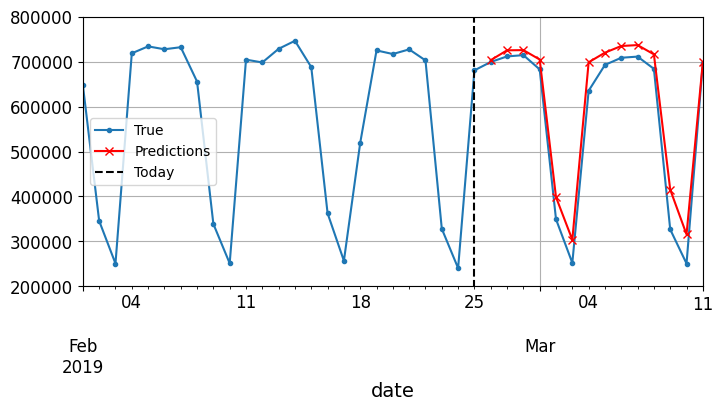

In [ ]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0], index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))

(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)

ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

The second option is to train an RNN **to predict the next 14 values in one shot.** We can still use a sequence-to-vector model, but it will output 14 values instead of 1. However, we first need to change the targets to be vectors containing the next 14 values. To do this, we can use `timeseries_dataset_from_array()` again, but this time asking it to create datasets without targets (`targets=None`) and with longer sequences, of length `seq_length + 14`. Then we can use the datasets’ `map()` method to apply a custom function to each batch of sequences, splitting them into inputs and
targets. In this example, we use the multivariate time series as input (using all five columns), and we forecast the rail ridership for the next 14 days:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

Now we just need the output layer to have 14 units instead of 1:

In [ ]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14) # Output is 14 dimension!
])

In [ ]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 5s 69ms/step - loss: 0.1590 - mae: 0.4254 - val_loss: 0.0288 - val_mae: 0.1948
Epoch 2/500
33/33 [==============================] - 2s 62ms/step - loss: 0.0202 - mae: 0.1616 - val_loss: 0.0138 - val_mae: 0.1287
Epoch 3/500
33/33 [==============================] - 4s 107ms/step - loss: 0.0133 - mae: 0.1292 - val_loss: 0.0106 - val_mae: 0.1128
Epoch 4/500
33/33 [==============================] - 3s 78ms/step - loss: 0.0111 - mae: 0.1170 - val_loss: 0.0088 - val_mae: 0.1036
Epoch 5/500
33/33 [==============================] - 2s 70ms/step - loss: 0.0099 - mae: 0.1096 - val_loss: 0.0079 - val_mae: 0.0965
Epoch 6/500
33/33 [==============================] - 2s 70ms/step - loss: 0.0090 - mae: 0.1033 - val_loss: 0.0070 - val_mae: 0.0915
Epoch 7/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0084 - mae: 0.0986 - val_loss: 0.0063 - val_mae: 0.0864
Epoch 8/500
33/33 [==============================] - 2s 71ms/step - loss: 0

33568.80694627762

After training this model, you can predict the next 14 values at once like this:

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 0s 197ms/step


This approach works quite well. Its forecasts for the next day are obviously better than its forecasts for 14 days into the future, but it doesn’t accumulate errors like the previous approach did. However, we can still do better, using a sequence-to-sequence (or seq2seq) model.

### Forecasting Using a Sequence-to-Sequence Model

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step. **In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.** The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just for the output at the last time step.

This means there will be many more error gradients flowing through the model, and they won’t have to flow through time as much since they will come from the output of each time step, not just the last one. This will both stabilize and speed up training. **To be clear, at time step 0 the model will output a vector containing the forecasts for time steps 1 to 14, then at time step 1 the model will forecast time steps 2 to 15, and so on.** In other words, the targets are sequences of consecutive windows, shifted by one time step at each time step. The target is not a vector anymore, but a sequence of the same length as the inputs, containing a 14-dimensional vector at each step.

Preparing the datasets is not trivial, since each instance has a window as input and a sequence of windows as output. One way to do this is to use the `to_windows()` utility function we created earlier, twice in a row, to get windows of consecutive windows. For example, let’s turn the series of numbers 0 to 6 into a dataset containing sequences of 4 consecutive windows, each of length 3:

In [ ]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

Now we can use the `map()` method to split these windows of windows into inputs and targets:

In [ ]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

Now the dataset contains sequences of length 4 as inputs, and the targets are sequences containing the next two steps, for each time step. For example, the first input sequence is `[0, 1, 2, 3]`, and its corresponding targets are `[[1, 2], [2, 3], [3, 4], [4, 5]]`, which are the next two values for each time step. 

Let’s create another little utility function to prepare the datasets for our sequence-to-sequence model. It will also take care of shuffling (optional) and batching:

In [ ]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

Now we can use this function to create the datasets:

In [ ]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

And lastly, we can build the sequence-to-sequence model:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14) # Output is 14 dimension
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [ ]:
seq2seq_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, None, 32)          1216      
                                                                 
 dense_6 (Dense)             (None, None, 14)          462       
                                                                 
Total params: 1,678
Trainable params: 1,678
Non-trainable params: 0
_________________________________________________________________


It is almost identical to our previous model: the only difference is that we set
`return_sequences=True` in the `SimpleRNN` layer. This way, it will output a sequence of vectors (each of size 32), instead of outputting a single vector at the last time step. The `Dense` layer is smart enough to handle sequences as input: it will be applied at each time step, taking a 32-dimensional vector as input and outputting a 14-dimensional vector. In fact, another way to get the exact same result is to use a `Conv1D` layer with a kernel size of 1: `Conv1D(14, kernel_size=1)`.

> `tf.Keras` offers a `TimeDistributed` layer that lets you apply any
vector-to-vector layer to every vector in the input sequences, at
every time step. It does this efficiently, by reshaping the inputs so
that each time step is treated as a separate instance, then it reshapes
the layer’s outputs to recover the time dimension. **In our case, we
don’t need it since the `Dense` layer already supports sequences as
inputs.**

In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid, learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 3s 68ms/step - loss: 0.0542 - mae: 0.2405 - val_loss: 0.0141 - val_mae: 0.1308
Epoch 2/500
33/33 [==============================] - 2s 48ms/step - loss: 0.0093 - mae: 0.1001 - val_loss: 0.0067 - val_mae: 0.0815
Epoch 3/500
33/33 [==============================] - 2s 48ms/step - loss: 0.0065 - mae: 0.0788 - val_loss: 0.0057 - val_mae: 0.0723
Epoch 4/500
33/33 [==============================] - 2s 49ms/step - loss: 0.0056 - mae: 0.0709 - val_loss: 0.0051 - val_mae: 0.0672
Epoch 5/500
33/33 [==============================] - 2s 70ms/step - loss: 0.0051 - mae: 0.0665 - val_loss: 0.0046 - val_mae: 0.0621
Epoch 6/500
33/33 [==============================] - 3s 80ms/step - loss: 0.0048 - mae: 0.0645 - val_loss: 0.0047 - val_mae: 0.0637
Epoch 7/500
33/33 [==============================] - 2s 48ms/step - loss: 0.0046 - mae: 0.0625 - val_loss: 0.0045 - val_mae: 0.0604
Epoch 8/500
33/33 [==============================] - 2s 49ms/step - loss: 0.

48454.705625772476

The training code is the same as usual. During training, all the model’s outputs are used, but after training only the output of the very last time step matters, and the rest can be ignored. For example, we can forecast the rail ridership for the next 14 days like this:

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 [==============================] - 0s 146ms/step


If you evaluate this model’s forecasts for $t+1$, you will find a validation MAE of 24,655. For $t+2$ it’s 29,310, and the performance continues to drop gradually as the model tries to forecast further into the future. At $t+14$, the MAE is 34,311.

In [ ]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 [==============================] - 0s 23ms/step
MAE for +1: 24,655
MAE for +2: 29,310
MAE for +3: 32,148
MAE for +4: 34,271
MAE for +5: 34,646
MAE for +6: 34,537
MAE for +7: 36,120
MAE for +8: 38,538
MAE for +9: 34,308
MAE for +10: 31,896
MAE for +11: 37,567
MAE for +12: 36,741
MAE for +13: 36,003
MAE for +14: 34,311


Simple RNNs can be quite good at forecasting time series or handling other kinds
of sequences, but they do not perform as well on long time series or sequences.

### Deep RNNs with Layer Norm

Let’s use `tf.keras` to implement Layer Normalization within a simple memory cell. We need to define a custom memory cell. It is just like a regular layer, except its `call()` method takes two arguments: the inputs at the current time step and the hidden states from the previous time step. Note that the `states` argument is a list containing one or more tensors. In the case of a simple RNN cell it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors (e.g., an `LSTMCell` has a long-term state and a short-term state). A cell must also have a `state_size` attribute and an `output_size` attribute. In a simple RNN, both are simply equal to the number of units. The following code implements a custom memory cell which will behave like a `SimpleRNNCell`, except it will also apply Layer Normalization at each time step:

In [ ]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 6s 108ms/step - loss: 0.0660 - mae: 0.2576 - val_loss: 0.0178 - val_mae: 0.1455
Epoch 2/5
33/33 [==============================] - 5s 165ms/step - loss: 0.0150 - mae: 0.1458 - val_loss: 0.0169 - val_mae: 0.1272
Epoch 3/5
33/33 [==============================] - 4s 119ms/step - loss: 0.0130 - mae: 0.1351 - val_loss: 0.0147 - val_mae: 0.1236
Epoch 4/5
33/33 [==============================] - 9s 265ms/step - loss: 0.0121 - mae: 0.1291 - val_loss: 0.0137 - val_mae: 0.1190
Epoch 5/5
3/3 [==============================] - 0s 33ms/step - loss: 0.0134 - mae: 0.1156


115600.42947530746

Similarly, you could create a custom cell to apply dropout between each time step. But there’s a simpler way: all recurrent layers and all cells provided by `tf.Keras` have a `dropout` hyperparameter and a [`recurrent_dropout`](https://www.tensorflow.org/guide/keras/rnn) hyperparameter: the **former defines the dropout rate to apply to the inputs** (at each time step), and the latter defines the **dropout rate for the hidden states** (also at each time step).

With these techniques, you can alleviate the unstable gradients problem and train an RNN much more efficiently. Now let’s look at how to deal with the short-term memory problem.

### LSTMs

In `tf.Keras`, you can simply use the `LSTM` layer instead of the `SimpleRNN` layer:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          4864      
                                                                 
 dense_8 (Dense)             (None, None, 14)          462       
                                                                 
Total params: 5,326
Trainable params: 5,326
Non-trainable params: 0
_________________________________________________________________


> Alternatively, you could use the general-purpose `tf.keras.layers.RNN` layer, giving it an `LSTMCell` as an argument. However, the `LSTM` layer uses an optimized implementation when running on a GPU.

In [ ]:
# keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True, input_shape=[None, 1]) also works
# However, the LSTM layer uses an optimized implementation when running on a GPU
# RNN layer is mostly useful when you define custom cells, as we did earl

In [ ]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 5s 47ms/step - loss: 0.0665 - mae: 0.2765 - val_loss: 0.0186 - val_mae: 0.1574
Epoch 2/5
33/33 [==============================] - 0s 13ms/step - loss: 0.0166 - mae: 0.1573 - val_loss: 0.0175 - val_mae: 0.1448
Epoch 3/5
33/33 [==============================] - 1s 14ms/step - loss: 0.0155 - mae: 0.1510 - val_loss: 0.0166 - val_mae: 0.1425
Epoch 4/5
33/33 [==============================] - 0s 13ms/step - loss: 0.0149 - mae: 0.1473 - val_loss: 0.0160 - val_mae: 0.1396
Epoch 5/5
3/3 [==============================] - 0s 27ms/step - loss: 0.0155 - mae: 0.1362


136158.73456001282

### GRUs

`tf.Keras` provides a `tf.keras.layers.GRU` layer: using it is just a matter of replacing `SimpleRNN` or `LSTM` with `GRU`. It also provides a `tf.keras.layers.GRUCell`, in case you want to create a custom cell based on a `GRU` cell.

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 4s 28ms/step - loss: 0.0568 - mae: 0.2545 - val_loss: 0.0187 - val_mae: 0.1694
Epoch 2/5
33/33 [==============================] - 0s 13ms/step - loss: 0.0162 - mae: 0.1500 - val_loss: 0.0156 - val_mae: 0.1373
Epoch 3/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0134 - mae: 0.1369 - val_loss: 0.0140 - val_mae: 0.1283
Epoch 4/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0121 - mae: 0.1286 - val_loss: 0.0128 - val_mae: 0.1229
Epoch 5/5
3/3 [==============================] - 0s 27ms/step - loss: 0.0121 - mae: 0.1179


117899.73080158234

### Using One-Dimensional Convolutional Layers to Process Sequences

The following model is the same as earlier, except it starts with a 1D
convolutional layer that downsamples the input sequence by a factor of 2, using a stride of 2. The kernel size is larger than the stride, so all inputs will be used to compute the layer’s output, and therefore the model can learn to preserve the useful information, dropping only the unimportant details. By shortening the sequences the convolutional layer may help the GRU layers detect longer patterns, so we can afford to double the input sequence length to 112 days. Note that we must also crop off the first three time steps in the targets: indeed, the kernel’s size is 4, so the first output of the convolutional layer will be based on the input time steps 0 to 3, and the first
forecasts will be for time steps 4 to 17 (instead of time steps 1 to 14). Moreover, we must downsample the targets by a factor of 2, because of the stride:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

conv_rnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          672       
                                                                 
 gru_1 (GRU)                 (None, None, 32)          6336      
                                                                 
 dense_10 (Dense)            (None, None, 14)          462       
                                                                 
Total params: 7,470
Trainable params: 7,470
Non-trainable params: 0
_________________________________________________________________


In [ ]:
longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112, shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid, learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 7s 33ms/step - loss: 0.0555 - mae: 0.2556 - val_loss: 0.0209 - val_mae: 0.1595
Epoch 2/5
31/31 [==============================] - 1s 21ms/step - loss: 0.0160 - mae: 0.1503 - val_loss: 0.0166 - val_mae: 0.1425
Epoch 3/5
31/31 [==============================] - 1s 36ms/step - loss: 0.0140 - mae: 0.1417 - val_loss: 0.0155 - val_mae: 0.1335
Epoch 4/5
31/31 [==============================] - 1s 28ms/step - loss: 0.0128 - mae: 0.1338 - val_loss: 0.0143 - val_mae: 0.1274
Epoch 5/5
1/1 [==============================] - 0s 154ms/step - loss: 0.0130 - mae: 0.1225


122495.1446056366

## Natural-language processing

### Preparing text data

Vectorizing process using `Python` may be done as follows:

In [ ]:
class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)

vectorizer = Vectorizer()
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
vectorizer.make_vocabulary(dataset)

In [ ]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)

[2, 3, 5, 7, 1, 5, 6]


In [ ]:
decoded_sentence = vectorizer.decode(encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


However, using something like this wouldn’t be very performant. In practice, you’ll work with the `tf.Keras` [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, which is fast and efficient and can be dropped directly into a `tf.data` pipeline or a `tf.Keras` model.

In [ ]:
# Configures the layer to return sequences of words encoded
# as integer indices.
text_vectorization = tf.keras.layers.TextVectorization(
    output_mode="int",
)

By default, the `TextVectorization` layer will use the setting “convert to lowercase and remove punctuation” for text standardization, and “split on whitespace” for tokenization.

But importantly, you can provide custom functions for standardization and tokenization, which means the layer is flexible enough to handle any use case. To index the vocabulary of a text corpus, just call the `adapt()` method of the layer with a `Dataset` object that yields strings, or just with a list of `Python` strings:

In [ ]:
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
text_vectorization.adapt(dataset)

Note that you can retrieve the computed vocabulary via `get_vocabulary()`—this can be useful if you need to convert text encoded as integer sequences back into words. The first two entries in the vocabulary are the mask token (index 0) and the OOV token (index 1). Entries in the vocabulary list are sorted by frequency, so with a realworld dataset, very common words like “the” or “a” would come first.

In [ ]:
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'erase',
 'write',
 'then',
 'rewrite',
 'poppy',
 'i',
 'blooms',
 'and',
 'again',
 'a']

For a demonstration, let’s try to encode and then decode an example sentence:

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)

tf.Tensor([ 7  3  5  9  1  5 10], shape=(7,), dtype=int64)


In [ ]:
inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


### Two approaches for representing groups of words: Sets and sequences

We’ll demonstrate bag-of-words and sequence approach on a well-known text classification benchmark: the IMDB movie review sentiment-classification dataset. Let’s process the raw
IMDB text data, just like you would do when approaching a new text-classification problem in the real world. You can check out the data [here](https://ai.stanford.edu/~amaas/data/sentiment/).

Let’s start by downloading the dataset from the Stanford page of Andrew Maas and uncompressing it

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  8848k      0  0:00:09  0:00:09 --:--:-- 16.4M


The `train/pos/` directory contains a set of 12,500 text files, each of which
contains the text body of a positive-sentiment movie review to be used as training data. The negative-sentiment reviews live in the `train/neg` directories. In total, there are 25,000 text files for training and another 25,000 for testing. There’s also a `train/unsup` subdirectory in there, which we don’t need. Let’s
delete it:

In [ ]:
!rm -r aclImdb/train/unsup

Take a look at the content of a few of these text files. Whether you’re working with text data or image data, remember to always inspect what your data looks like before you dive into modeling it:

In [ ]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

Next, let’s prepare a validation set by setting apart 20% of the training text files in a new directory, `aclImdb/val`:

In [ ]:
base_dir = Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

Let’s create three `Dataset` objects for training, validation, and testing:

In [ ]:
batch_size = 32

train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


These datasets yield inputs that are TensorFlow `tf.string` tensors and targets that are `int32` tensors encoding the value “0” or “1.”

In [ ]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'I think that this is possibly the funniest movie I have ever seen. Robert Harling\'s script is near perfect, just check out the "quotes" section; on second thought, just rent the DVD, since it\'s the delivery that really makes the lines sing.<br /><br />Sally Field gives a comic, over-the-top performance like you\'ve never seen from her anywhere else, and Kevin Kline is effortlessly hilarious. Robert Downey, Jr. is typically brilliant, and in a very small role, Kathy Najimy is a riot as the beleaguered costumer. I was never much of a fan of Elisabeth Shue, but she\'s great here as the one *real* person surrounded by a bevy of cartoon characters on the set of "The Sun Also Sets" -- that rumbling you feel beneath you is Hemingway rolling over in his grave. Either that, or he\'s laughing really hard.<br /><br />Five stars. Funny, funny, funny.', shape=(), dtype=s

#### Single words (unigrams) with binary encoding

First, let’s process our raw text datasets with a `TextVectorization` layer so that they yield multi-hot encoded binary word vectors. Our layer will only look at single words (that is to say, unigrams). We will limit the vocabulary to the 20,000 most frequent words. Otherwise we’d be indexing every word in the training data— potentially tens of thousands of terms that only occur once or
twice and thus aren’t informative. In general, 20,000 is the right vocabulary size for text classification.

In [ ]:
# Encode the output tokens as multi-hot binary vectors.
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot",
)
# Prepare a dataset that only yields raw text inputs (no labels).
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

You can try to inspect the output of one of these datasets:

In [ ]:
for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


Next, let’s write a reusable model-building function that we’ll use in all of our experiments in this section.

In [ ]:
# A densely connected NN
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = tf.keras.layers.Dense(hidden_dim, activation="relu")(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(optimizer="nadam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

Finally, let’s train and test our model.

In [ ]:
model = get_model()
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("binary_1gram.keras", save_best_only=True)
]
model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

model = tf.keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_11 (Dense)            (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 9s 12ms/step - loss: 0.3861 - accuracy: 0.8356 - val_loss: 0.2701 - val_accuracy: 0.8942
Epoch 2/10
625/625 [========================

This gets us to a test accuracy of 88.4%: not bad!

#### Bigrams with binary encoding

Of course, discarding word order is very reductive, because even atomic concepts can be expressed via multiple words. The `TextVectorization` layer can be configured to return arbitrary N-grams: bigrams, trigrams, etc. Just pass an `ngrams=N` argument as in the following listing.



In [ ]:
text_vectorization = tf.keras.layers.TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)

Let’s test how our model performs when trained on such binary-encoded bags of
bigrams.

In [ ]:
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

model = tf.keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_13 (Dense)            (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 8s 9ms/step - loss: 0.3697 - accuracy: 0.8462 - val_loss: 0.2565 - val_accuracy: 0.8986
Epoch 2/10
625/625 [=======================

We’re now getting 89.7% test accuracy, a marked improvement! Turns out local order is pretty important.

#### Bigrams with TF-IDF encoding

You can also add a bit more information to this representation by counting how many times each word or N-gram occurs. TF-IDF is so common that it’s built into the `TextVectorization` layer. All you need to do to start using it is to switch the `output_mode` argument to `tf_idf`.

In [ ]:
text_vectorization = tf.keras.layers.TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

text_vectorization.adapt(text_only_train_ds)

Let’s train a new model with this scheme.

In [ ]:
tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("tfidf_2gram.keras", save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

model = tf.keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_15 (Dense)            (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 8s 10ms/step - loss: 0.5177 - accuracy: 0.7586 - val_loss: 0.3129 - val_accuracy: 0.8848
Epoch 2/10
625/625 [======================

This gets us an 89.1% test accuracy on the IMDB classification task: it doesn’t seem to be particularly helpful in this case. However, for many text-classification datasets, it would be typical to see a one-percentage-point increase when using TF-IDF compared to plain binary encoding.

### Processing words as a sequence: The sequence model approach

What if, instead of manually crafting order-based features, we exposed the model to raw word sequences and let it figure out such features on its own? This is what sequence models are about. Let’s try out a sequence model in practice. First, let’s prepare datasets that return integer sequences. In order to keep a manageable input size, **we’ll truncate the inputs after the first 600 words.**

> This is a reasonable choice, since the average review length is 233 words, and only 5% of reviews are longer than 600 words.

In [ ]:
max_length = 600
max_tokens = 20000
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Next, let’s make a model. The simplest way to convert our integer sequences to vector sequences is to one-hot encode the integers (each dimension would represent one possible term in the vocabulary). On top of these one-hot vectors, we’ll add a simple bidirectional LSTM.

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64") # One input is a sequence of integers
embedded = tf.one_hot(inputs, depth=max_tokens) # A 3D tensor of shape [batch size, time steps, embedding size]
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(embedded)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # Classification layer
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="nadam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               5128448   
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
_________________________________________________

Now, let’s train our model:

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras", save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = tf.keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 169s 259ms/step - loss: 0.6148 - accuracy: 0.6773 - val_loss: 0.6323 - val_accuracy: 0.6720
Epoch 2/10
625/625 [==============================] - 163s 261ms/step - loss: 0.3993 - accuracy: 0.8426 - val_loss: 0.3126 - val_accuracy: 0.8762
Epoch 3/10
625/625 [==============================] - 162s 260ms/step - loss: 0.2752 - accuracy: 0.8935 - val_loss: 0.6013 - val_accuracy: 0.7044
Epoch 4/10
625/625 [==============================] - 163s 261ms/step - loss: 0.7385 - accuracy: 0.6064 - val_loss: 0.8323 - val_accuracy: 0.5076
Epoch 5/10
625/625 [==============================] - 164s 262ms/step - loss: 0.3485 - accuracy: 0.8608 - val_loss: 0.3655 - val_accuracy: 0.8506
Epoch 6/10
625/625 [==============================] - 163s 261ms/step - loss: 0.4231 - accuracy: 0.8137 - val_loss: 0.3651 - val_accuracy: 0.8582
Epoch 7/10
625/625 [==============================] - 163s 261ms/step - loss: 0.2117 - accuracy: 0.9301 - val_loss: 0.3304 -

A first observation: this model will train very slowly, especially compared to the lightweight model of the previous section. This is because our inputs are quite large: each input sample is encoded as a matrix of size `(600, 20000)` (600 words per sample, 20,000 possible words). That’s 12,000,000 floats for a single movie review. Our bidirectional LSTM has a lot of work to do.

#### Understanding word embeddings

Let's try word embedding. What makes a good word-embedding space depends heavily on your task: the perfect word-embedding space for an English-language movie-review sentiment-analysis model may look different from the perfect embedding space for an English-language legal-document classification model, because the importance of certain semantic relationships varies from task to task. It’s thus reasonable to learn a new embedding space with every new task. Fortunately, backpropagation makes this easy, and `tf.Keras` makes it even easier. It’s about learning the weights of a layer: the `Embedding` layer.

In [ ]:
# The Embedding layer takes at least two arguments: the number of
# possible tokens and the dimensionality of the embeddings (here, 256).
embedding_layer = tf.keras.layers.Embedding(input_dim=max_tokens, output_dim=256)

**The `Embedding` layer is best understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors.** The Embedding layer takes as input a rank-2 tensor of integers, of shape `(batch_size, sequence_length)`, where each entry is a sequence of integers. The layer then returns a 3D floating-point tensor of shape` (batch_size, sequence_length, embedding_dimensionality)`.

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just as with any other layer. During training, these word vectors are gradually adjusted via backpropagation, structuring the space into something the downstream model can exploit. Once fully trained, the embedding space will show a lot of structure—a kind of structure specialized for the specific problem for which you’re training your model.

Let’s build a model that includes an `Embedding` layer and benchmark it on our task:

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.keras.layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(embedded)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = tf.keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

It trains much faster than the one-hot model (since the LSTM only has to process
256-dimensional vectors instead of 20,000-dimensional), and its test accuracy is comparable (86%). We’re still some way off from the results of our basic bigram model. Part of the reason why is simply that the model is looking at slightly less data: the bigram model processed full reviews, while our sequence model truncates sequences after 600 words.

#### Understanding padding and masking

One thing that’s slightly hurting model performance here is that our input sequences are full of zeros. This comes from our use of the `output_sequence_length=max_length` option in `TextVectorization` (with `max_length` equal to 600): **sentences longer than 600 tokens are truncated to a length of 600 tokens, and sentences shorter than 600 tokens are padded with zeros** at the end so that they can be concatenated together with other sequences to form contiguous batches.

We’re using a bidirectional RNN: two RNN layers running in parallel, with one processing the tokens in their natural order, and the other processing the same
tokens in reverse. **The RNN that looks at the tokens in their natural order will spend its last iterations seeing only vectors that encode padding—possibly for several hundreds of iterations if the original sentence was short**. The information stored in the internal state of the RNN will gradually fade out as it gets exposed to these meaningless inputs.

We need some way to tell the RNN that it should skip these iterations. There’s an API for that: *masking*. The `Embedding` layer is capable of generating a "mask" that corresponds to its input data. This mask is a tensor of ones and zeros (or `True/False` booleans), of shape `(batch_size, sequence_length)`, where the entry `mask[i, t]` indicates where timestep `t` of sample `i` should be skipped or not (the timestep will be skipped if `mask[i, t]` is 0 or `False`, and processed otherwise).

By default, this option isn’t active — you can turn it on by passing `mask_zero=True` to your `Embedding` layer. You can retrieve the mask with the `compute_mask()` method:

In [ ]:
embedding_layer = tf.keras.layers.Embedding(input_dim=10, output_dim=256, mask_zero=True)

In [ ]:
some_input = [
    [4, 3, 2, 1, 0, 0, 0],
    [5, 4, 3, 2, 1, 0, 0],
    [2, 1, 0, 0, 0, 0, 0]
]

mask = embedding_layer.compute_mask(some_input)
mask

<tf.Tensor: shape=(3, 7), dtype=bool, numpy=
array([[ True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True, False, False],
       [ True,  True, False, False, False, False, False]])>

In practice, you will almost never have to manage masks by hand. Instead, `tf.Keras` will automatically pass on the mask to every layer that is able to process it. This mask will be used by RNN layers to skip masked steps. If your model returns an entire sequence, the mask will also be used by the loss function to skip masked steps in the output sequence. Let’s try retraining our model with masking enabled:

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.keras.layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs) # You can turn mask on by passing mask_zero=True
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(embedded)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)


model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras", save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = tf.keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

This time we get to 88% test accuracy — a small but noticeable improvement.

#### Using pretrained word embeddings

Sometimes you have so little training data available that you can’t use your data alone to learn an appropriate task - specific embedding of your vocabulary. In such cases, instead of learning word embeddings jointly with the problem you want to solve, you can load embedding vectors from a precomputed embedding space that you know is highly structured and exhibits useful properties. There are various precomputed databases of word embeddings that you can download and use in a `tf.Keras` `Embedding` layer. `Word2vec` is one of them. Another popular one is called `GloVe`, which was developed by Stanford researchers in 2014.

First, let’s download the GloVe word embeddings precomputed on the 2014
English Wikipedia dataset. It’s an 822 MB zip file containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens).

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-04-24 10:36:45--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-24 10:36:45--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-24 10:36:46--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Let’s parse the unzipped file (a `.txt` file) to build an index that maps words (as strings) to their vector representation.

In [ ]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Next, let’s build an embedding matrix that you can load into an `Embedding` layer. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry `i` contains the `embedding_dim` - dimensional vector for the word of index `i` in the reference word index (built during tokenization).

In [ ]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Finally, we use a `Constant` initializer to load the pretrained embeddings in an `Embedding` layer. So as not to disrupt the pretrained representations during training, we freeze the layer via `trainable=False`:

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

We’re now ready to train a new model—identical to our previous model, but leveraging the 100-dimensional pretrained GloVe embeddings instead of 128-dimensional learned embeddings.

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(embedded)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras", save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

model = tf.keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
____________________________________________

Leveraging pretrained embeddings can be very helpful when you’re working with a smaller dataset.

### The Transformer encoder (Optional)

The encoder part of transformer can be used for text classification—it’s a very generic module that ingests a sequence and learns to turn it into a more useful representation. Let’s implement a Transformer encoder using `tf.Keras` subclassing API.

In [ ]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim  # Size of the input token vectors
        self.dense_dim = dense_dim  # Size of the inner dense layer
        self.num_heads = num_heads  # Number of attention heads
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
    # Computation goes in call().
    def call(self, inputs, mask=None): 
        # The mask that will be generated by the Embedding layer will be 2D, but
        # the attention layer expects to be 3D or 4D, so we expand its rank. 
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    # Implement serialization so we can save the model.
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

When you write custom layers, make sure to implement the `get_config()` method: this enables the layer to be reinstantiated from its `config` dict, which is useful during model saving and loading.

To add positional encoding, we’ll do something simpler and more effective: we’ll learn position embedding vectors the same way we learn to embed word indices. We'll then proceed to add our position embeddings to the corresponding word embeddings, to obtain a position-aware word embedding. **It is noted that 
neural networks don’t like very large input values, or discrete input distributions** therefore simply adding a position information as interger is not a good idea.

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    # A downside of position embeddings is that the sequence length needs to be known in advance.
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        # Prepare an Embedding layer for the token indices.
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        # And another one for the token positions
        self.position_embeddings = tf.keras.layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        # Add both embedding vectors together
        return embedded_tokens + embedded_positions
    
    # Like the Embedding layer, this layer should be able to generate a
    # mask so we can ignore padding 0s in the inputs. The compute_mask
    # method will called automatically by the framework, and the
    # mask will get propagated to the next layer.
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

All you have to do to start taking word order into account is swap the old `Embedding` layer with our position-aware version.

In [ ]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras", save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = tf.keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        5273600   
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder (Transf  (None, None, 256)        543776    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                           

We get to 88.3% test accuracy, a solid improvement that clearly demonstrates the
value of word order information for text classification. This is our best sequence model so far!

## Hugging Face’s `Transformers` Library

It’s impossible to talk about transformers today without mentioning Hugging Face, an AI company that has built a whole ecosystem of easy-to-use open source tools for NLP, vision, and beyond. The central component of their ecosystem is the `Transformers` library, which allows you to easily download a pretrained model, including its corresponding tokenizer, and then fine-tune it on your own dataset, if needed. Plus, the library supports `TensorFlow`, `PyTorch`, and `JAX` (with the high-level `Flax` library).

The simplest way to use the `Transformers` library is to use the transformers.
`pipeline()` function: you just specify which task you want, such as sentiment analysis, and it downloads a default pretrained model, ready to be used:

In [ ]:
classifier = pipeline("sentiment-analysis")  # many other tasks are available
result = classifier("The actors were very convincing.")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


The result is a `Python` list containing one dictionary per input text:

In [ ]:
result

[{'label': 'POSITIVE', 'score': 0.9998071789741516}]

In this example, the model correctly found that the sentence is positive, with around 99.98% confidence. Of course, you can also pass a batch of sentences to the model (Models can be very biased. For example, it may like or dislike some countries depending on the data it was trained on, and how it is used, so use it with care):

In [ ]:
classifier(["I am from India.", "I am from Iraq."]) # Note that is has bias

[{'label': 'POSITIVE', 'score': 0.9896161556243896},
 {'label': 'NEGATIVE', 'score': 0.9811071157455444}]

The `pipeline()` function uses the default model for the given task. For example, for text classification tasks such as sentiment analysis, it defaults to `distilbert-base-uncased-finetuned-sst-2-english` — a DistilBERT model with
an uncased tokenizer, trained on English Wikipedia and a corpus of English books, and fine-tuned on the Stanford Sentiment Treebank v2 (SST 2) task. 

In [ ]:
classifier.model, classifier.tokenizer 

(DistilBertForSequenceClassification(
   (distilbert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0-5): 6 x TransformerBlock(
           (attention): MultiHeadSelfAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=True)
           )
           (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
           (ffn): FFN(
             (dropout): Dropout(p=

It’s also possible to manually specify a different model. For example, you could use a DistilBERT model fine-tuned on the Multi-Genre Natural Language Inference (MultiNLI) task, **which classifies two sentences into three classes: contradiction, neutral, or entailment**. Here is how:

In [ ]:
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"
classifier_mnli = pipeline("text-classification", model=model_name)
classifier_mnli("She loves me. [SEP] She loves me not.")

[{'label': 'contradiction', 'score': 0.9790191650390625}]

The `pipeline()` API is very simple and convenient, but sometimes you will need more control. For such cases, the `Transformers` library provides many classes, including all sorts of tokenizers, models, configurations, callbacks, and much more. For example, let’s load the same DistilBERT model, along with its corresponding tokenizer, using the `TFAutoModelForSequenceClassification` and `AutoTokenizer` classes:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

Some layers from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli and are newly initialized: ['dropout_23']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next, let’s tokenize a couple of pairs of sentences. In this code, we activate padding and specify that we want `TensorFlow` tensors instead of `Python` lists:

In [ ]:
token_ids = tokenizer(["I like soccer. [SEP] We all love soccer!",
                       "Joe lived for a very long time. [SEP] Joe is old."],
                      padding=True, return_tensors="tf")

> Instead of passing `"Sentence 1 [SEP] Sentence 2"` to the
tokenizer, you can equivalently pass it a tuple: `("Sentence 1",
"Sentence 2")`.

The output is a dictionary-like instance of the `BatchEncoding` class, which contains the sequences of token IDs, as well as a mask containing 0s for the padding tokens:

In [ ]:
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

If you set `return_token_type_ids=True` when calling the tokenizer, you will also get an extra tensor that indicates which sentence each token belongs to. This is needed by some models, but not DistilBERT. Next, we can directly pass this `BatchEncoding` object to the model; it returns a `TFSequenceClassifierOutput` object containing its predicted class logits:

In [ ]:
outputs = model(token_ids)
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.1123812 ,  1.178679  ,  1.4101001 ],
       [-0.01478288,  1.0962466 , -0.9919953 ]], dtype=float32)>, hidden_states=None, attentions=None)

Lastly, we can apply the softmax activation function to convert these logits to class probabilities, and use the `argmax()` function to predict the class with the highest probability for each input sentence pair:

In [ ]:
Y_probas = tf.keras.activations.softmax(outputs.logits)
Y_probas

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.01619703, 0.43523598, 0.54856706],
       [0.22655995, 0.6881722 , 0.08526783]], dtype=float32)>

In [ ]:
Y_pred = tf.argmax(Y_probas, axis=1)
Y_pred  # 0 = contradiction, 1 = entailment, 2 = neutral

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1])>

In this example, the model correctly classifies the first sentence pair as neutral (the fact that I like soccer does not imply that everyone else does) and the second pair as an entailment (Joe must indeed be quite old).

If you wish to fine-tune this model on your own dataset, you can train the model
as usual with `tf.Keras` since it’s just a regular `tf.Keras` model with a few extra methods. However, because the model outputs logits instead of probabilities, you must use the `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)` loss instead of the usual `sparse_categorical_crossentropy` loss. Moreover, the model does not support `BatchEncoding` inputs during training, so you must use its data attribute to get a regular dictionary instead:

In [ ]:
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]
X_train = tokenizer(sentences, padding=True, return_tensors="tf").data
y_train = tf.constant([0, 2])  # contradiction, neutral
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2
1/1 [==============================] - 47s 47s/step - loss: 0.6666 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 71ms/step - loss: 0.3430 - accuracy: 1.0000


Hugging Face has also built a `Datasets` library that you can use to easily download a standard dataset (such as IMDb) or a custom one, and use it to fine-tune your model. It’s similar to `TensorFlow` `Datasets`, but it also provides tools to perform common preprocessing tasks on the fly, such as masking. The list of datasets is available at [https://huggingface.co/datasets](https://huggingface.co/datasets).

This should get you started with Hugging Face’s ecosystem. To learn more, you can head over to [https://huggingface.co/docs](https://huggingface.co/docs) for the documentation, which includes many tutorial notebooks, videos, the full API, and more.

### Deal with IMDB (Optional)

In [ ]:
imdb = load_dataset("imdb")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
imdb['train'][100]

{'text': "Terrible movie. Nuff Said.<br /><br />These Lines are Just Filler. The movie was bad. Why I have to expand on that I don't know. This is already a waste of my time. I just wanted to warn others. Avoid this movie. The acting sucks and the writing is just moronic. Bad in every way. The only nice thing about the movie are Deniz Akkaya's breasts. Even that was ruined though by a terrible and unneeded rape scene. The movie is a poorly contrived and totally unbelievable piece of garbage.<br /><br />OK now I am just going to rag on IMDb for this stupid rule of 10 lines of text minimum. First I waste my time watching this offal. Then feeling compelled to warn others I create an account with IMDb only to discover that I have to write a friggen essay on the film just to express how bad I think it is. Totally unnecessary.",
 'label': 0}

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

# If we use AutoModelForSequenceClassification, it will use pytorch model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
 
tokenized_imdb = imdb.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="my_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.227100,0.193795,0.926880


TrainOutput(global_step=1563, training_loss=0.2581237346334329, metrics={'train_runtime': 1578.5525, 'train_samples_per_second': 15.837, 'train_steps_per_second': 0.99, 'total_flos': 3281068438885632.0, 'train_loss': 0.2581237346334329, 'epoch': 1.0})

## References

1. [https://github.com/ageron/handson-ml3/](https://github.com/ageron/handson-ml3/) 

2. [https://github.com/fchollet/deep-learning-with-python-notebooks](https://github.com/fchollet/deep-learning-with-python-notebooks)

3. [https://androidkt.com/save-and-load-fine-tuned-huggingface-transformers-model-from-local-disk/](https://androidkt.com/save-and-load-fine-tuned-huggingface-transformers-model-from-local-disk/)

4. [https://github.com/nlp-with-transformers/notebooks/tree/main](https://github.com/nlp-with-transformers/notebooks/tree/main)